# **Predictive Maintenance: Failure Prediction using NASA PHM08 Dataset**

### **Problem Statement**

This dataset describes the degradation of an aircraft engine. The dataset was used for the prognostics challenge competition at the International Conference on Prognostics and Health Management (PHM08).

Using multivariate sensor data that monitor the operating conditions of engines before failure, two Machine Learning approaches are developed, tested and evaluated. These models include:

- A Regression Pycaret ML Model to predict RUL based on sensor data readings at any given time cycle for each any given engine

- A Multiclass Classification Tensorflow Deep Learning that predicts failure risk of an engine given a 30 time-cycle window of multivariate sensor data


### **Dataset**

The dataset is available through Kaggle in the following link:

https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

and can alternatively be downloaded directly from the NASA Open Data Repository:

https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

The Datasets consists of multiple multivariate time series for 21 sensors across 218 engines. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. 

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 

### **The project will be completed across the following phases:**

1) Exploratory Data Analysis (EDA): Data Preprocessing, Feature Engineering & Data Visualization

2) Failure Prediction Regression using PyCaret ML Models

3) Failure Risk Level Prediction with Tensorflow Deep Learning

4) Results, Conclusion & Future Work


## **1) Exploratory Data Analysis (EDA): Data Preprocessing, Feature Engineering & Data Visualization**

Exploratory Data Analysis (EDA) is a preliminary approach to analyzing datasets with the primary goal of summarizing their main characteristics with tools such as statistical graphs. It helps Data Scientists and Machine Learning Engineers understand the data they are working with to address the problem statement.

is a critical phase in the data analysis process that involves preparing and understanding raw data before modeling. It encompasses three essential components: Data Preprocessing, Feature Engineering, and Data Visualization. 

EDA is an indispensable step in the data science process, as it ensures data quality, allows for the creation of meaningful features that contribute to model accuracy, and provides a visual context that aids in the interpretation of complex datasets. By refining and visualizing data, EDA empowers analysts and data scientists to make informed decisions, uncover hidden patterns, and effectively communicate findings to stakeholders.


Below I import Python Libraries (Tensorflow, Pycaret, sklearn, Numpy, Pandas, matplotlib & seaborn) that are required to complete the Machine Learning project.

In [212]:
#Importing all libraries we will be using for this project

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import RegressionExperiment

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [213]:
import warnings

# Ignore all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

tf.get_logger().setLevel('ERROR')
tf.get_logger().setLevel('FATAL')

## **Data Preprocessing**

Data Preprocessing involves cleaning and transforming raw data into a format suitable for analysis by handling missing values, removing outliers, and addressing inconsistencies. In this project, we will be converting .txt files, into Pandas DataFrames, and then 3D Numpy Arrays to be input into a deep learning model.

In [214]:
index_col_names=['unit_id','time_cycle']
operat_set_col_names=['oper_set{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sm_{}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit_id', 'time_cycle', 'oper_set1', 'oper_set2', 'oper_set3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']


Below, we can use .head() to visualize the first 5 rows of our training data. As can be observed, there are columns for unit_id, time_cycle, 3 operational setting columns and 21 sensor columns.

In [215]:
train_df=pd.read_csv('CMaps/train_FD001.txt',delim_whitespace=True,names=all_col)
train_df.to_csv('train.csv')
train_df.head()

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


We can find quick insights into the statistical distribution of our data using the Pandas .describe() function below. For instance, we see that the maximum time cycle for any unit is 362 - which would be our maximum RUL.

In [216]:
train_df.describe()

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Below, we import the test data and RUL ground truth data in the same fashion.

The RUL is then appended to each data point in our multivariate sensor data for each unit in the cells below and serves as the target variable.

As the given RUL corresponds to the total life cycle of each unit, programming logic is required to count the RUL down by 1 for each time cycle that passes, until the unit fails at RUL=0, which is the end of each sensor data sequence.

In [217]:
test_df=pd.read_csv('CMaps/test_FD001.txt',delim_whitespace=True,names=all_col)
test_df.to_csv('test.csv')
test_df.head()

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [218]:
y_true=pd.read_csv('CMaps/RUL_FD001.txt',delim_whitespace=True,names=['RUL'])
y_true['unit_id']=y_true.index+1

In [219]:
#find maximum time cycle for each unit d
max_time_cycle=train_df.groupby('unit_id')['time_cycle'].max()
rul = pd.DataFrame(max_time_cycle).reset_index()
rul.columns = ['unit_id', 'max']
rul.head()

,unit_id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [220]:
#merge train_df with rul dataframe based on number unit, that is the column join, using the left join
train_df = train_df.merge(rul, on=['unit_id'], how='left')

In [221]:
train_df['RUL'] = train_df['max'] - train_df['time_cycle']
train_df.drop('max', axis=1, inplace=True)

In [222]:
test_df['RUL']=0
for i in range(1,101):
    test_df.loc[test_df.unit_id==i,'RUL']=range(int(y_true.RUL[y_true.unit_id==i])+len(test_df[test_df.unit_id==i])-1,
                                      int(y_true.RUL[y_true.unit_id==i])-1,-1)

In [223]:
test_df.iloc[:,[0,1,-1]].head()

,unit_id,time_cycle,RUL
0,1,1,142
1,1,2,141
2,1,3,140
3,1,4,139
4,1,5,138


## **Feature Engineering**

Feature Engineering focuses on creating new informative features or modifying existing ones to enhance a model's performance. This step often involves scaling, encoding categorical variables, and extracting relevant information. In this section, the 

Feature Engineering is a process by which we determine how well out input features predict the output (i.e. how good of a predictor of RUL is sm_14).

We may also check how correlated out features are to each other.

In [224]:
train_df.corr()

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
unit_id,1.000000,0.078753,-0.017895,-0.006197,NaN,NaN,0.014133,0.012621,0.026116,NaN,...,0.044230,-0.059473,0.022486,NaN,0.013513,NaN,NaN,-0.020589,-0.016465,0.078753
time_cycle,0.078753,1.000000,-0.004527,0.016132,NaN,NaN,0.549898,0.543947,0.624577,NaN,...,0.477523,0.370324,0.588676,NaN,0.566995,NaN,NaN,-0.583597,-0.585923,-0.736241
oper_set1,-0.017895,-0.004527,1.000000,0.011660,NaN,NaN,0.009030,-0.005651,0.009544,NaN,...,0.002318,-0.004469,0.007652,NaN,0.002599,NaN,NaN,-0.005713,-0.014559,-0.003198
oper_set2,-0.006197,0.016132,0.011660,1.000000,NaN,NaN,0.007266,0.009068,0.014673,NaN,...,0.018156,-0.006310,0.014156,NaN,0.012280,NaN,NaN,-0.010554,-0.007846,-0.001948
oper_set3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_2,0.014133,0.549898,0.009030,0.007266,NaN,NaN,1.000000,0.602610,0.714949,NaN,...,0.661792,0.179752,0.675975,NaN,0.629886,NaN,NaN,-0.661841,-0.668050,-0.606484
sm_3,0.012621,0.543947,-0.005651,0.009068,NaN,NaN,0.602610,1.000000,0.678413,NaN,...,0.600963,0.237137,0.639921,NaN,0.600017,NaN,NaN,-0.625941,-0.633901,-0.584520
sm_4,0.026116,0.624577,0.009544,0.014673,NaN,NaN,0.714949,0.678413,1.000000,NaN,...,0.745158,0.190748,0.758459,NaN,0.703499,NaN,NaN,-0.748067,-0.745193,-0.678948
sm_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observing the Correlation Matrix, we note the following important insights about our predictive features:

* oper_set3 is not correlated with the other features, nor the target (RUL)
* sensor 1, 5,10,16,18,19 are not correlated with other features, nor the target (RUL)

The data visualization of the time series data from these sensors confirm as much below.

## **Data Visualization**

Data Visualization employs graphical techniques to illustrate patterns, relationships, and trends within the dataset, aiding in the identification of insights that might be overlooked in raw data.

Observing the subplots below, we can see that some sensors trend up right before failure, while others trend down. We also see that some sensors show a fixed value for all sensors in all units - Thus we can discard these as they we won't be able to predict Risk of Failure with these.

Below, the multivariate data of 21 sensors for 218 engines can be observed against its RUL until the point of failure.

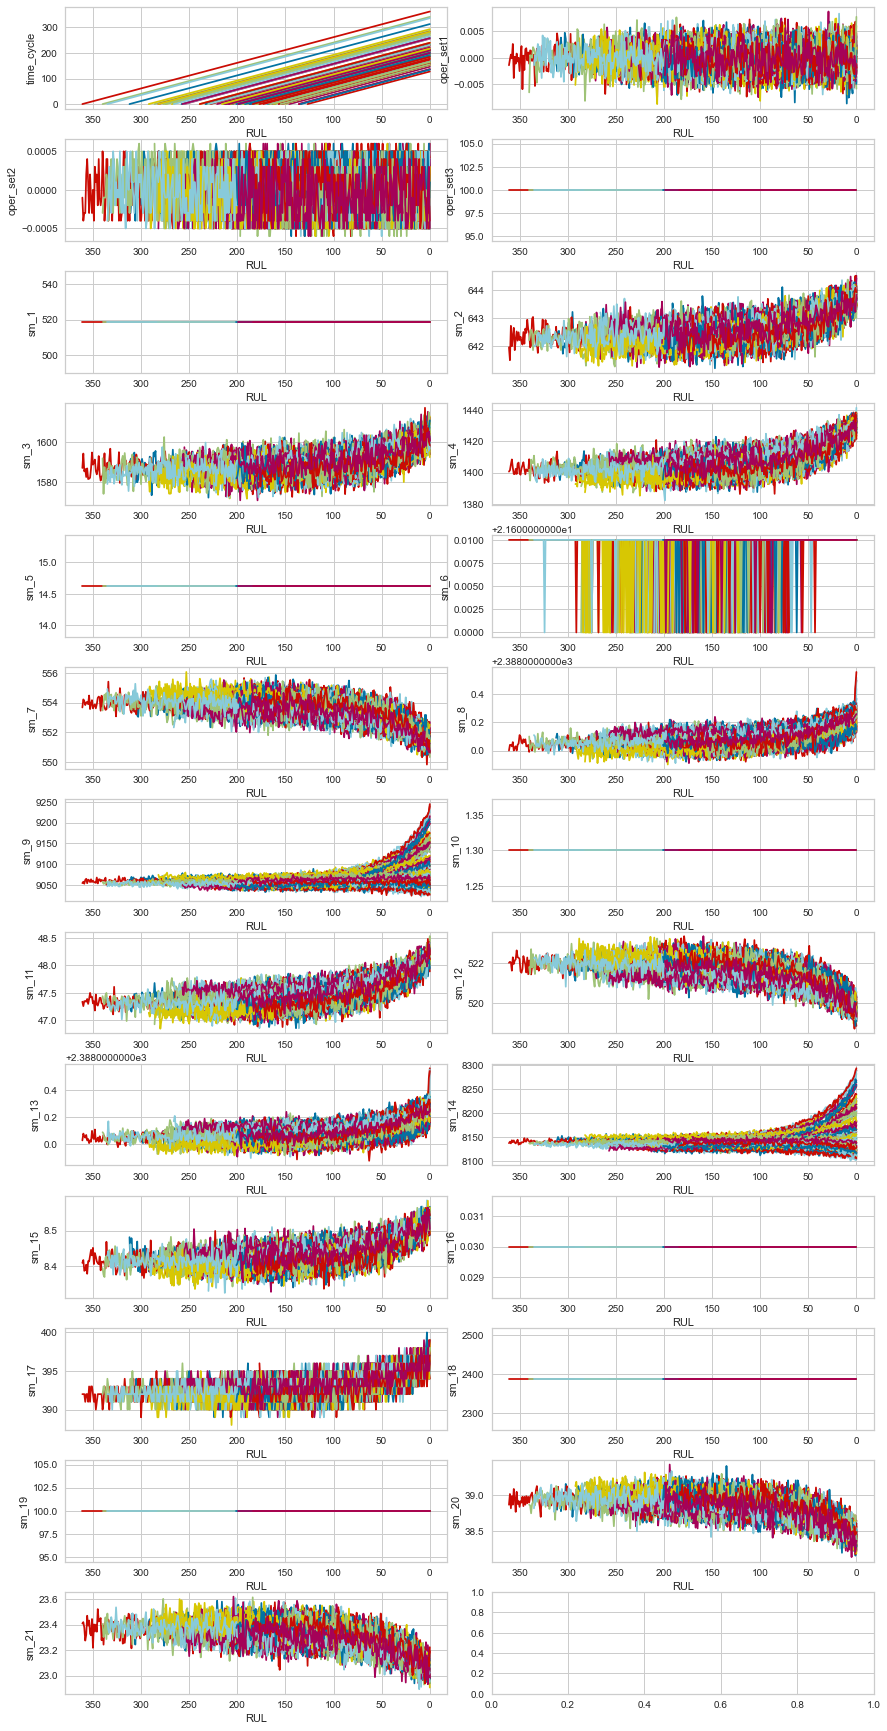

In [226]:
fig, ax = plt.subplots(13, 2, figsize=(12, 24))
fig.tight_layout()
r, c = 0, 0

for v_idx, v in enumerate(all_col[1:]):
    for i in train_df['unit_id'].unique():
        data = train_df[train_df['unit_id'] == i]
        ax[r][c].plot('RUL', v, data=data)
        
    ax[r][c].set_xlabel('RUL')
    ax[r][c].set_ylabel(v)
    
    # Reverse the x-axis by setting the limits in reverse order
    ax[r][c].set_xlim(ax[r][c].get_xlim()[::-1])

    if c < 1:
        c += 1
    elif c == 1:
        r += 1
        c -= 1


Thus, we confirm from data visualization that the sensors identified in feature engineering are indeed not predictors of the output. We will proceed to drop these to reduce noise in our model to improve prediction performance.

In [227]:
cols_drop=['oper_set3','sm_1','sm_5','sm_6','sm_10','sm_14','sm_16','sm_18','sm_19']
train_df = train_df.drop(cols_drop, axis = 1)
test_df = test_df.drop(cols_drop, axis = 1)

In [228]:
train_df.head()

,unit_id,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [229]:
test_df.head()

,unit_id,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,138


In [230]:
data = pd.concat([train_df, test_df], ignore_index=True, axis=0)

# **2) Failure Prediction Regression using PyCaret ML Models**

In this section of the project, we will create and benchmark several ML models in Pycaret to perform regression on the multivariate sensor data. In this experiment, each row of the data will be used to predict the corresponding RUL - and thus give an estimate of when the unit will fail. As such, the sequential nature of the data is not modelled - simply the sensor readings per unit at any given time cycle.

Pycaret is a machine learning library in Python that allows us to build an end-to-end machine learning pipeline through training, testing, benchmarking and deploying several model types. It allows us to easily compare the performance of several model types to select the ideal solution for a given dataset.


In [231]:
exp = RegressionExperiment()

In [232]:
# check the type of exp
type(exp)

pycaret.regression.oop.RegressionExperiment

In [233]:
from pycaret.regression import *
s = setup(data, target = 'RUL', session_id = 123)

,Description,Value
0,Session id,123
1,Target,RUL
2,Target type,Regression
3,Original data shape,"(33727, 18)"
4,Transformed data shape,"(33727, 18)"
5,Transformed train set shape,"(23608, 18)"
6,Transformed test set shape,"(10119, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


In the benchmarking table below, we see the LightGBM model performs best at this regression task across the board - achieving an MAE of 16 (meaning that, on average, the predicted RUL is with 16 time cycles of the actual RUL) and an R^2 value of 0.88 (indicating high correlation between actual and predicted value).

In [234]:
# compare baseline models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,16.9090,540.9600,23.2518,0.8802,0.2698,0.2109,0.2490
rf,Random Forest Regressor,20.3033,811.8919,28.4879,0.8202,0.2860,0.2366,12.3520
gbr,Gradient Boosting Regressor,23.6225,1030.3721,32.0955,0.7718,0.3565,0.3032,2.5300
et,Extra Trees Regressor,23.5580,1057.8969,32.5207,0.7657,0.3041,0.2619,4.3220
dt,Decision Tree Regressor,24.9467,1587.5081,39.8329,0.6484,0.3963,0.2939,0.1670
lr,Linear Regression,31.6273,1647.3158,40.5833,0.6352,0.5313,0.5921,0.7000
ridge,Ridge Regression,31.6255,1647.1607,40.5814,0.6352,0.5310,0.5920,0.0330
lar,Least Angle Regression,31.6273,1647.3158,40.5833,0.6352,0.5313,0.5921,0.0350
br,Bayesian Ridge,31.6297,1647.4948,40.5855,0.6351,0.5315,0.5920,0.0400
lasso,Lasso Regression,31.9560,1676.2999,40.9390,0.6287,0.5417,0.5998,0.0410


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

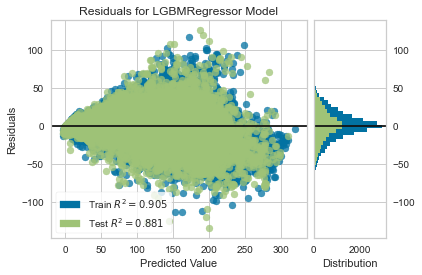

In [235]:
# plot residuals
plot_model(best, plot = 'residuals')

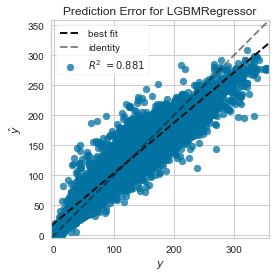

In [236]:
# plot error
plot_model(best, plot = 'error')

Below is a Feature Importance Plot, where we see that sm_9, sm_11 and sm_12 are the sensors that are the best predictors of failure (unit_id & time_cycle can be ignored)

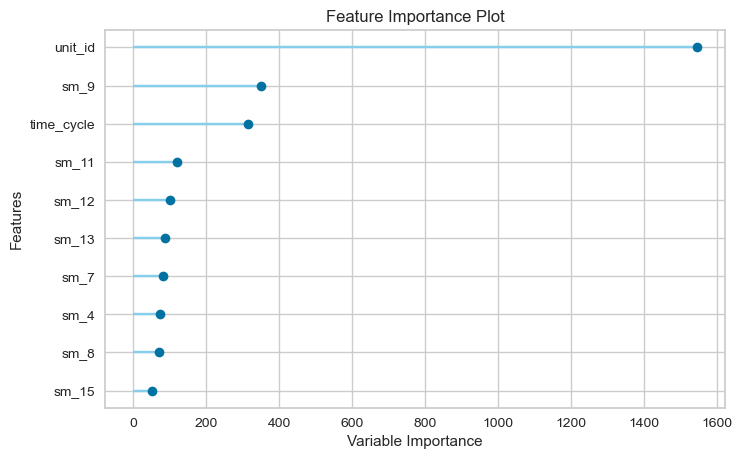

In [237]:
# plot feature importance
plot_model(best, plot = 'feature')

We can also use Pycaret to get predictions using our best model. in the cells below, we can see 5 predictions using the model, and scrolling to the right of the Dataframe, see that the Actual RUL is close to the predicted RULs.

In [238]:
# predict on test set
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.1480,537.1883,23.1773,0.8810,0.2606,0.1984


In [239]:
# show predictions df
holdout_pred.head()

,unit_id,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL,prediction_label
6249,32,29,0.0019,0.0002,642.580017,1589.569946,1410.510010,553.409973,2388.110107,9049.799805,47.570000,521.210022,2388.149902,8.4308,393,38.759998,23.287300,162,160.474674
22972,20,91,-0.0003,-0.0003,642.359985,1581.979980,1405.709961,553.549988,2388.090088,9063.559570,47.119999,521.799988,2388.040039,8.4289,394,39.040001,23.292999,109,110.518290
24277,30,116,0.0023,-0.0001,642.380005,1597.030029,1407.750000,553.150024,2388.120117,9056.200195,47.480000,521.419983,2388.100098,8.4357,395,38.639999,23.179800,142,92.977541
26466,47,25,-0.0041,-0.0003,642.539978,1590.180054,1406.140015,553.489990,2388.110107,9039.540039,47.480000,520.880005,2388.149902,8.3943,394,38.919998,23.290100,183,178.762073
5096,25,217,0.0023,0.0002,643.059998,1604.459961,1431.459961,552.059998,2388.159912,9127.099609,47.959999,520.640015,2388.149902,8.5333,397,38.520000,23.086800,13,9.177913


# **3) Failure Risk Level Prediction with Tensorflow Deep Learning**

In this section of the notebook, the CNN-LSTM Deep Learning model depicted below is created using the Tensorflow Library. This is a completely novel solution proposed, developed and tested by myself, and to my knowledge, a 2D-CNN LSTM model has not been tested on this dataset. This model predicts engine Risk of failure across three risk levels (High, Medium, Low) using sequential multivariate sensor data. 

In this model, 30 time cycle windows of 15 sensor multivariate data are concatenated and treated as an image. These 15x30 snapshots are inserted into the CNN portion of the model where convolution is performed using two layers of 64 3x3 kernels. This layer captures important spatial hierarchies and complex relationships between the multivariate sensor data. The resultant feature maps are then Max Pooled with a pool size of 2x2.

This data is then flattened to be 1-dimensional, and then the data is processed through the two LSTM layers (100 & 50 units respectively) to capture important short-term and long-term relationships in the multivariate data to predict failure risk level. 

The data is then sent through a 2-layer Feed-Forward Neural Network (200 & 50 neurons respectively) with two dropout layers consisting of a 20% dropout-rate in between these layers. The dropout layers randomly set 20% of parameters to 0 to prevent model overfitting.

Finally, the output layer is a dense layer of 3 neurons. A SoftMax activation is applied to predict the Failure Risk level associated with the 30-time cycle window of multivariate sensor data.

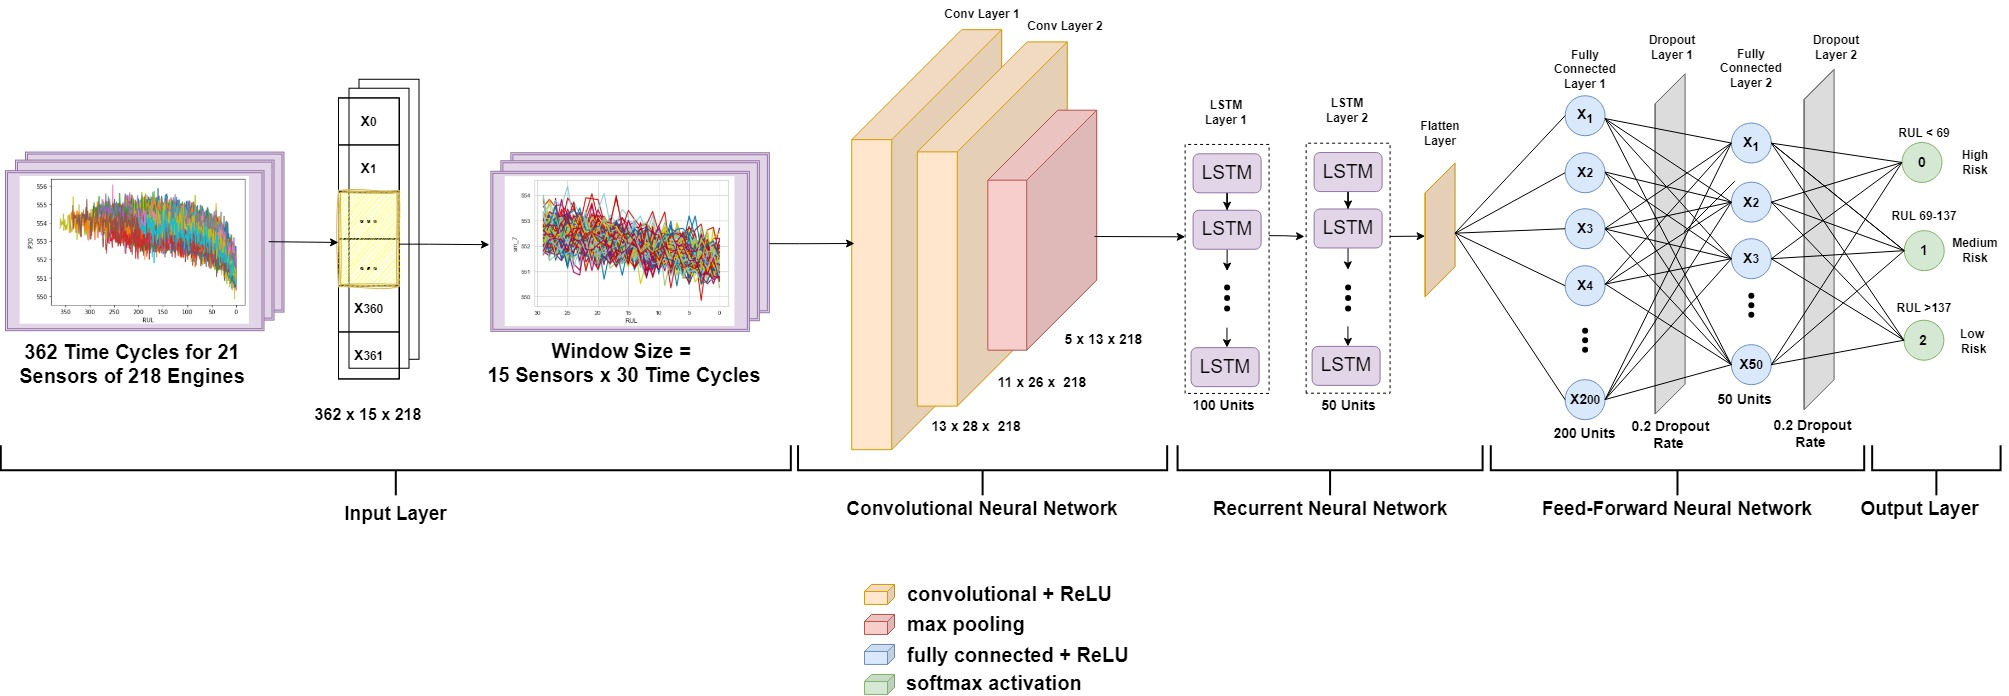

## **Data Preprocessing to format data for compatibility with Tensorflow model**

In the cell below, each row in our DataFrame (which includes multivariate sensor data for each unit at each time cycle) is categorized for Asset Failure Risk across three risk levels: High, Medium Low.

**A High failure risk** is assigned when the RUL of the unit is less than 69-time cycles.

**A Medium failure risk** is assigned when the RUL of the unit is more than 69-time cycles but less than 137.

**A Low failure risk** is assigned when RUL exceeds 137.

These thresholds were assigned to achieve balance in the dataset across the three classes and prevent bias/variance in the model.


In [240]:
conditions = [
    (train_df['RUL'] < 69),
    (train_df['RUL'] >= 69) & (train_df['RUL'] <= 137),
    (train_df['RUL'] > 137)
]

risk_levels = ['High', 'Medium', 'Low']

# Create a new column 'Risk' based on conditions
train_df['Risk'] = np.select(conditions, risk_levels, default='Unknown')

train_df.head()

,unit_id,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL,Risk
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191,Low
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190,Low
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189,Low
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188,Low
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187,Low


As can be seen below, the three classes are well balanced.

In [241]:
train_df['Risk'].value_counts()

High      6900
Medium    6885
Low       6846
Name: Risk, dtype: int64

In the following two cell, I define a function to create 15 x 30 windows of the multivariate data, with a moving window of 1 for each sensor.

So for a sensor of size 15 x 362, this function creates 333 separate snapshots of 15 x 30 windows, to store in a 3d array of shape (333, 15, 30).
    
    

In [242]:
def create_3d_array_from_array(arr, window_size):
    rows, columns = arr.shape
    slices = columns - window_size + 1

    # Initialize a 3D array to store the subarrays
    subarrays_3d = np.zeros((slices, rows, window_size))

    # Iterate through the columns with the moving window
    for i in range(slices):
        subarrays_3d[i, :, :] = arr[:, i:i + window_size]

    return subarrays_3d

The cell below one-hot encodes the y (target) vector. This is necessary for categorical values in a Tensorflow model.

In [243]:
columns_to_drop = ['RUL', 'Risk', 'A','B','C']
columns_to_ignore = ['unit_id', 'RUL', 'Risk', 'A','B','C']
encoder = OneHotEncoder(sparse=False, categories='auto')

y = pd.DataFrame(train_df['Risk'])
y = y.values

# One-hot encode the categorical variable
encoder = OneHotEncoder(sparse=False, categories='auto')
y_onehot = encoder.fit_transform(y.reshape(-1, 1))
column_names = ['A', 'B', 'C']
y_onehot = pd.DataFrame(y_onehot,columns=column_names)

new_df = pd.concat([train_df, y_onehot], axis=1)
new_df

,unit_id,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,...,sm_13,sm_15,sm_17,sm_20,sm_21,RUL,Risk,A,B,C
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,2388.02,8.4195,392,39.06,23.4190,191,Low,0.0,1.0,0.0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,2388.07,8.4318,392,39.00,23.4236,190,Low,0.0,1.0,0.0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,2388.03,8.4178,390,38.95,23.3442,189,Low,0.0,1.0,0.0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,2388.08,8.3682,392,38.88,23.3739,188,Low,0.0,1.0,0.0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,2388.04,8.4294,393,38.90,23.4044,187,Low,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,...,2388.26,8.4956,397,38.49,22.9735,4,High,1.0,0.0,0.0
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,...,2388.22,8.5139,395,38.30,23.1594,3,High,1.0,0.0,0.0
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,...,2388.24,8.5646,398,38.44,22.9333,2,High,1.0,0.0,0.0
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,...,2388.23,8.5389,395,38.29,23.0640,1,High,1.0,0.0,0.0


The cell below standardizes each of our predictive features - this is done to ensure that numerical features are on a similar scale, preventing one feature from dominating others. 

In [244]:
# Create a list of features to standardize (exclude the specified columns)
features_to_standardize = [col for col in new_df.columns if col not in columns_to_ignore]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected features
new_df[features_to_standardize] = scaler.fit_transform(new_df[features_to_standardize])

# Display the DataFrame
new_df.head()


,unit_id,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,...,sm_13,sm_15,sm_17,sm_20,sm_21,RUL,Risk,A,B,C
0,1,-1.565170,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,...,-1.058890,-0.603816,-0.781710,1.348493,1.194427,191,Low,0.0,1.0,0.0
1,1,-1.550652,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,...,-0.363646,-0.275852,-0.781710,1.016528,1.236922,190,Low,0.0,1.0,0.0
2,1,-1.536134,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,...,-0.919841,-0.649144,-2.073094,0.739891,0.503423,189,Low,0.0,1.0,0.0
3,1,-1.521616,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,...,-0.224597,-1.971665,-0.781710,0.352598,0.777792,188,Low,0.0,1.0,0.0
4,1,-1.507098,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,...,-0.780793,-0.339845,-0.136018,0.463253,1.059552,187,Low,0.0,1.0,0.0


The cell below simply loops through all units in our data to create 15 x 30 windows to store in a single 3D array: X1. similarly, it creates the corresponding target vector y to be the risk level associated with each window.

The sequential model in the figure above requires the time cycles to be in the x-axis while the multivariate sensor data is in the y column. Thus we will need to augment the data by transposing it (example below):

In [245]:
example_window =new_df[new_df.unit_id==(1)]
example_window =example_window.drop(columns=columns_to_drop)
example_window.T.head()

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
unit_id,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
time_cycle,-1.565170,-1.550652,-1.536134,-1.521616,-1.507098,-1.492579,-1.478061,-1.463543,-1.449025,-1.434507,...,1.077132,1.091650,1.106169,1.120687,1.135205,1.149723,1.164241,1.178759,1.193277,1.207796
oper_set1,-0.315980,0.872722,-1.961874,0.324090,-0.864611,-1.961874,0.461248,-1.550401,0.369810,-1.504681,...,0.049775,0.186933,0.369810,1.238476,-2.144751,-3.059137,-0.270260,-1.230366,0.004055,0.415529
oper_set2,-1.372953,-1.031720,1.015677,-0.008022,-0.690488,-0.349255,0.333211,1.015677,0.333211,0.333211,...,0.333211,1.015677,0.333211,-1.031720,-0.008022,1.015677,0.674444,0.333211,-1.372953,-0.008022
sm_2,-1.721725,-1.061780,-0.661813,-0.661813,-0.621816,-1.161771,-0.401834,-0.241847,-1.121775,-1.941707,...,1.118041,2.777904,2.237949,1.657996,1.278028,2.137957,2.997886,1.917975,1.318024,1.717992


In [246]:
for i in range(100):
    
    snipped=new_df[new_df.unit_id==(i+1)]
    X =snipped.drop(columns=columns_to_drop)
    y = snipped[column_names]
    
    X = X.T
    X.columns = X.iloc[0]
    X = X[1:]
    X = X[1:]
    
    X = X.values
    y = y.values
    y = y[29:]
    
    #X_pad = pad_array(X, 362)
    X_clean = create_3d_array_from_array(X, 30)
    
    if i == 0:
        X1 =  X_clean
        y1 =  y
        
    else:
        
        X1 = np.concatenate([X1, X_clean], axis=0)
        y1 = np.concatenate([y1, y], axis=0)

Below we see the final shape of our features (X1) and targets (y1) arrays.

Thus, we have, in total, 17731 total samples to train, validate and test our deep learning Tensorflow model.

In [247]:
X1.shape,y1.shape

((17731, 15, 30), (17731, 3))

Note that the target matrix is one-hot encoded across 3 columns to represent our three risk level targets (Tensorflow cannot model categorical values):

In [248]:
y1

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Let us observe what a random single sample and corresponding target looks like:

In [249]:
X1[21], y[21]

(array([[ 0.09549395,  1.55851132, -0.45313756,  1.0555991 ,  0.00405537,
         -0.54457614, -1.09320765,  0.55268688, -1.00176907,  0.64412547,
          0.23265183, -1.91615492,  0.68984476,  0.14121325, -0.1788218 ,
         -0.1788218 , -0.8188919 , -1.36752341,  0.00405537,  1.51279202,
          0.23265183, -1.23036553, -0.04166392, -0.59029544,  0.14121325,
          0.00405537,  0.87272193, -0.63601473, -1.458962  , -0.45313756],
        [-0.00802181, -1.03172035,  1.01567674, -1.3729532 ,  0.67444389,
         -1.3729532 ,  1.69814244, -0.34925466, -0.00802181,  1.69814244,
         -1.03172035, -1.3729532 , -0.34925466,  0.67444389, -0.69048751,
         -0.00802181, -0.69048751, -0.34925466, -1.3729532 ,  1.35690959,
         -1.3729532 ,  1.69814244,  0.67444389, -0.00802181,  0.33321104,
          1.69814244,  0.33321104,  1.69814244, -0.34925466,  1.01567674],
        [ 0.17811825, -1.08177806, -0.60181756,  0.17811825, -1.04178135,
         -0.48182744, -0.66181262, -

Thus we see the 21st 15 x 30 window samples has a corresponding risk level of 0,1,0, which is our Low Risk class.

## **Model Creation and Training**

Below, the Deep Learning CNN-LSTM model is created and trained on our data using an 80-10-10 train, validation and test data split.

Note the special care in the LSTM layers given to prevent exploding gradients (an issue I have had in the past):

- recurrent_initializer='orthogonal': This parameter sets the initializer for the recurrent weights of the LSTM. The 'orthogonal' initializer initializes the recurrent weights to an orthogonal matrix, which can aid in training stability.

- recurrent_constraint=tf.keras.constraints.MaxNorm(3): This part applies a constraint to the recurrent weights of the LSTM. The MaxNorm constraint limits the maximum norm of the weights to 3. It helps prevent the exploding gradients problem during training.

Cross K-Fold Validation is unavailable in Tensorflow, but we can combine model training with the StratifiedKFold library in sklearn to perform K-fold validation on the Tensorflow model.

A confusion matrix is created at the end to visually evaluate the performance of the model in predicting the correct Failure Risk classification

Training on Fold 1...
100/100 [==============================] - 1s 8ms/step
Fold 1 Accuracy: 0.9317
Training on Fold 2...
100/100 [==============================] - 1s 8ms/step
Fold 2 Accuracy: 0.9145
Training on Fold 3...
100/100 [==============================] - 1s 8ms/step
Fold 3 Accuracy: 0.9395
Training on Fold 4...
100/100 [==============================] - 1s 8ms/step
Fold 4 Accuracy: 0.9386
Training on Fold 5...
100/100 [==============================] - 1s 8ms/step
Fold 5 Accuracy: 0.9132

Average Accuracy: 0.9275


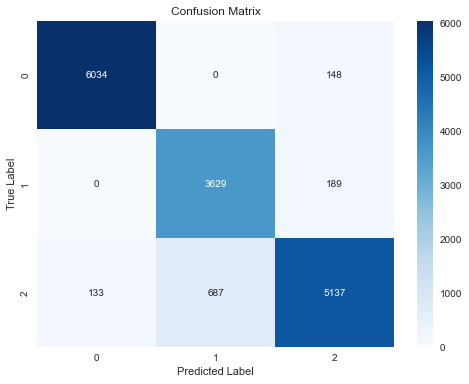

In [250]:
x = X1
y = y1

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your input shape is (height, width, channels) for each sample
input_shape = (15, 30, 1)  

# Perform train-validation-test split (80-10-10)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Convert y_train_temp to a one-dimensional array
y_train_temp_single_column = np.argmax(y_train_temp, axis=1)

# Initialize StratifiedKFold with 5 folds (adjust as needed)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the results of each fold
fold_accuracies = []
all_true_classes = []
all_predicted_classes = []

# Iterate over the folds
for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(x_train_temp, y_train_temp_single_column), 1):
    print(f"Training on Fold {fold}...")

    # Create a new instance of the model for each fold
    model = Sequential()

    # Add your model architecture here
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((5, 13 * 64)))
    model.add(LSTM(100, activation='relu', recurrent_initializer='orthogonal', recurrent_constraint=tf.keras.constraints.MaxNorm(3), return_sequences=True))
    model.add(LSTM(50, activation='relu', recurrent_initializer='orthogonal', recurrent_constraint=tf.keras.constraints.MaxNorm(3)))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Get the current fold's data
    x_train, y_train = x_train_temp[train_indices], y_train_temp[train_indices]
    x_val, y_val = x_train_temp[val_indices], y_train_temp[val_indices]

    # Train the model
    model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=0)

    # Evaluate the model on the validation set
    predictions = model.predict(x_val)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_val, axis=1)

    # Store true and predicted classes for each fold
    all_true_classes.extend(true_classes)
    all_predicted_classes.extend(predicted_classes)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(true_classes, predicted_classes)
    fold_accuracies.append(fold_accuracy)

    print(f"Fold {fold} Accuracy: {fold_accuracy:.4f}")

# Print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy: {average_accuracy:.4f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_true_classes, all_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Above, we see that our model performs at a high degree of accuracy in classifying Failure Risk level using the 15x30 windows of multivariate sensor data.

In the confusion matrix, 

**Class 0** Corresponds to High Risk of Failure.

**Class 1** Corresponds to Medium Risk of Failure.

**Class 2** Corresponds to Low Risk of Failure.

Below is a summary of our model, which corresponds to the figure at the beginning of this section.

In [251]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 13, 28, 64)        640       
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 26, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 13, 64)        0         
 g2D)                                                            
                                                                 
 reshape_13 (Reshape)        (None, 5, 832)            0         
                                                                 
 lstm_26 (LSTM)              (None, 5, 100)            373200    
                                                                 
 lstm_27 (LSTM)              (None, 50)                30200     
                                                     

## **Model Testing and Peformance Evaluation**

In the following section, the model is evaluated on the test set - data it has not seen in the training phase.

The cell below recieves Failure Risk predictions from the model, and compares them to the actual failure risk level.

In [252]:
# Convert one-hot encoded labels to actual class labels
actual_classes = np.argmax(y_test, axis=1)

# Use the trained model to make predictions on the test set
predictions = model.predict(x_test)

# Get the predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Create a DataFrame to store actual and predicted labels
result_df = pd.DataFrame({'Actual': actual_classes, 'Predicted': predicted_classes})

# Display the DataFrame
result_df


56/56 [==============================] - 0s 7ms/step


,Actual,Predicted
0,2,2
1,1,1
2,2,1
3,1,1
4,2,2
...,...,...
1769,0,2
1770,2,2
1771,0,0
1772,0,0


In the cell below, Test Accuracy, Predicison, Recall and F1 score are all calculated - showing scores of 91%-92% in each metric

In [253]:
# Compute accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)

# Compute precision, recall, and F1 score
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
f1 = f1_score(actual_classes, predicted_classes, average='weighted')

# Display the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Accuracy: 0.9149
Precision: 0.9255
Recall: 0.9149
F1 Score: 0.9154


A Final Confusion matrix of the model's performance on the test data is displayed below:

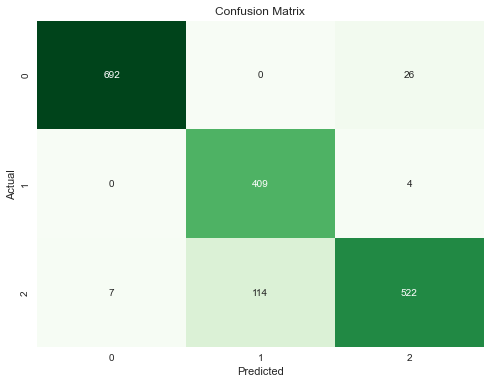

In [254]:
# Create a confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Convert the confusion matrix to a DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Results and Future Work**

In this project, we observed two Machine Learning algorithm types achieve high performance in both Predictive Maintenance Regression and Multiclass Classification, with the LightGBM Regression model predicted RUL with a MAE of 16.9 and R^2 value of 0.88, and the Tensorflow Deep Learning Multiclass Classification model able to predict Failure Risk level to 92-93% Accuracy, Precision, Recall, and F1 on the NASA PHM08 Dataset.

This may serve as a template to applying predictive maintenance in other industries (such as the utility sector), should one have similar rich, vast datasets.
